![Logo](figures/GOE_Logo_Quer_IPC_Farbe_RGB.png)
# Constructing a HDNNP using RuNNer and pyiron
**Alexander L. M. Knoll, and Moritz R. Schäfer** 

Behler Group, Theoretische Chemie, Institut für Physikalische Chemie


## Constructing a High-Dimensional Neural Network Potential for Lithium Aluminum Alloys using RuNNer and pyiron

This Jupyter Notebook is written for the RuNNer tutorial at the workshop "Potentials" from 08-10 June, 2022 by **Marius Herbold, Alexander L. M. Knoll, and Moritz R. Schäfer** (marius.herbold@chemie.uni-goettingen.de, aknoll@chemie.uni-goettingen.de, moritzrichard.schaefer@uni-goettingen.de, Georg-August-Universität Göttingen, Theoretische Chemie, Institut für Physikalische Chemie).


For this tutorial it is intended to use the RuNNer release version 1.2, available in conda-forge. 
The most recent version of RuNNer is [hosted on Gitlab](https://gitlab.com/TheochemGoettingen/RuNNer). For access please contact Prof. Dr. Jörg Behler (joerg.behler@uni-goettingen.de).

In [6]:
import numpy as np

import matplotlib.pyplot as plt
import ipympl
import ipywidgets as widgets

from pyiron_atomistics import Project
from pyiron_contrib.atomistics.runner.job import RunnerFit
from pyiron_contrib.atomistics.runner.utils import container_to_ase

from ase.geometry import get_distances

from runnerase import generate_symmetryfunctions

%matplotlib widget

## Background

**RuNNer** is a stand-alone Fortran program for the construction of high-dimensional neural network potentials (HDNNPs), written mainly by Jörg Behler. The central assumption made in constructing a HDNNP is that the total energy of the system $E_{\mathrm{tot}}$ [can be separated into atomic contributions $E_i$](https://www.doi.org/10.1103/PhysRevLett.98.146401). HDNNP relates the local environment of the atoms to their atomic energies $E_i$, which contribute to the sum of all $N$ atomic energies, resulting in the total energy of the system $E_\mathrm{tot}$.

\begin{align}
    E_\mathrm{tot} = \sum_{i}^{N}E_i\notag
\end{align}

Every atomic energy is described by an atomic neural network (NN), which is element-specific. The entirety of all atomic NNs composes a HDNNP, whose general architecture is shown below for a binary system.

<div>
<img src="figures/2g.png" width="500"/>
</div>

As you can see, the atomic contributions in this model are predicted independently from each other. Therefore, the model can easily describe systems with differering numbers of atoms: adding or removing an atom corresponds to adding or removing a row in the figure shown above. This ability is what puts the "high-dimensional" into the name "HDNNP". 

Each atomic neural networks receives input information about the local atomic environment up to a certain cutoff radius $R_{\mathrm{c}}$. This information is encoded based on the Cartesian coordinates in many-body descriptors, so-called [atom-centered symmetry functions (ACSF or just SF)](https://www.doi.org/10.1063/1.3553717). More details about this are shown below. For each atom, the values of multiple SFs compose a SF vector $G$ which is the input layer of the atomic NNs.

Atomic NNs look like this:

<div>
<img src="figures/ann.png" width="500"/>
</div>

Every value in the SF vector $G$ serves as one piece of input information to the atomic NN. We refer to the circles in the figure as _nodes_ (from graph theory) or _neurons_ (from neural science). The information from the input nodes flows through the atomic NN from left to right: the input layer is followed by a configurable number of hidden layers which consist, in turn, of an arbitrary number of _hidden nodes_. At the end, all information is collected in the output layer, which in our case is interpreted as the atomic energy contribution of the atom under consideration. The input nodes and the hidden nodes in the first layer are connected by weights. Moreover, the hidden and output nodes carry a bias value.

During training, the weights and biases are optimized using backpropagation to represent best the data in the training data set.

## Definition of the Symmetry Functions (SFs)

SFs provide the input for the NN and describe the local atomic environment of each atom. In principle, one could also use Cartesian coordinates to capture the atomic positions in a structure. As Cartesian coordinates describe the absolute positions of atoms the numerical input to the atomic NNs would change with translation or rotation of the system. However, these actions do not influence the energy of the system and different numerical inputs belonging to the same NN output lead to large training errors.

In contrast, SFs describe the relative positions of the atoms to each other and are hence translationally and rotationally invariant. We differentiate two types of SFs: radial SF depend on the distance between atom pairs and serve as a measure for their bond order. Angular SFs additionally depend on the interatomic angles.

### The Cutoff Function

The cutoff function $f_{\mathrm{c}}$ ensures that only the neighbors within one atomic environment counts towards the symmetry function values. The cutoff radius $R_\mathrm{c}$ (usually $12\,\mathrm{bohr}$) defines how much of the local atomic environment is considered. All SFs and their derivatives will decrease to zero if the pairwise distance is larger than $R_\mathrm{c}$. There are several cutoff funtions defined in **RuNNer** and we will use here

\begin{equation}
    f_{c}(R_{ij}) = 
    \begin{cases}
    0.5 \cdot [\cos(\pi x) + 1]& ~ \text{for $R_{ij} \leq R_\mathrm{c}$},\\
    0& ~ \text{for $R_{ij} > R_\mathrm{c}$}
    \end{cases}
\end{equation}

with the atomic distance $R_{ij}$, the cutoff radius $R_\mathrm{c}$, and $x = \frac{R_{ij}}{R_{\mathrm{c}}}$.

Take a look at the figure below for a graphical representation of the cutoff radius in a periodic system: the red atom is the central atom for which the SF values will be calculated. All yellow atoms lie within in the cutoff radius and will therefore contribute to the SF values.

<div>
<img src="figures/Rc.png" width="500"/>
</div>

### The Radial Symmetry Functions

To define the parameters for the radial SFs, it is important to know the shortest bond distance for each element combination in your data set. Usually, 5-6 radial SF are used for any element pair, with different $\eta$ values to increase the resolution for structure description. It is possible to shift the maximum of the radial SF $G^2$ by $R_{s}$.

\begin{equation}
    G_{i}^{2} = \sum_{j}^{}e^{-\eta (R_{ij} - R_{s})^2} \cdot f_{c}(R_{ij}).
\end{equation}

In most applications, the Gaussian exponents $\eta$ for the radial SFs are chosen such that the SF turning points are equally distributed between the cutoff radius and specific minimum pairwise distance in the training dataset (small eta $\eta$ = max. contraction). In RuNNer, you can either define element pair specific SF or define global SF which are used for every element combination. It is also possible to define different cutoff radii for the SF, even though this is rarely helpful and therefore not recommended.

Below, you can see a graphical representation of the radial symmetry functions including the cutoff function for a cutoff radius of 12 Bohr.

<div>
<img src="figures/radials.png" width="800"/>
</div>

### The Angular Symmetry Functions

The same rules apply to the angular SFs. Here, however, three atomic positions are included in the calculation.

\begin{equation*}
    G_{i}^{3} = 2^{\zeta - 1}\sum_{j}^{} \sum_{k}^{} \left[( 1 + \lambda \cdot cos \theta_{ijk})^{\zeta} \cdot e^{-\eta (R_{ij}^2 + R_{ik}^2 + R_{jk}^2)} \cdot f_{\mathrm{c}}(R_{ij}) \cdot f_{\mathrm{c}}(R_{ik}) \cdot f_{\mathrm{c}}(R_{jk}) \right]
\end{equation*}

The angle $\theta_{ijk} = \frac{\mathbf{R}_{ij} \cdot \mathbf{R}_{ik}}{R_{ij} \cdot R_{ik}}$ is centered at atom $i$. For most system, we use permutations of $\zeta = \{1, 2, 4, 16\}$, $\eta = 0$, and $\lambda$ = $\{+1, -1\}$. If many atoms of each element are present, angular SFs are usually not critical and a default set of SFs can be used.

<div>
<img src="figures/angulars.png" width="800"/>
</div>

##  The Third and Fourth Generations of NN Potentials

Due to time limitations, we will only focus on the model described above which is known as the second generation of HDNNPs (see [here](https://www.doi.org/10.1103/PhysRevLett.98.146401), and [here](https://www.doi.org/10.1002/anie.201703114), and [here](https://www.doi.org/10.1002/qua.24890)). However, in recent years third- and fourth-generation HDNNPs were developed by the Behler group.

### Repetition: Second Generation HDNNP

<div>
<img src="figures/2g.png" width="500">
</div>

### Third Generation HDNNP

In second-generation HDNNPs only atomic interactions inside the cutoff sphere are taken into account. The resulting short-ranged potentials are well-suited to describe local bonding even for complex atomic environments. However, it can be expected that for many systems long-range interactions, primarily electrostatics, will be important.

To overcome those limitations, third-generation NNs (see [here](https://www.doi.org/10.1103/PhysRevB.83.153101), and [here](https://www.doi.org/10.1063/1.3682557)) define a second set of atomic neural networks to construct environment-dependent atomic charges. They can then be used to calculate the long-range electrostatic energy without truncation. The total energy of the system is then given by the sum of the short-range and the electrostatic energies.

<div>
<img src="figures/3g.png" width="800"/>
</div>

### Fourth Generation HDNNP

While the use of environment-dependent charges is a clear step forward, they are not sufficient if long-range charge transfer is present.

When dealing with systems where long-range charge transer is present, the usage of fourth-generation NNs (see [here](https://www.doi.org/10.1038/s41467-020-20427-2), and [here](https://www.doi.org/10.1021/acs.accounts.0c00689)) is recommended. Here, environment-dependent electronegativities $\chi$ are computed first. They will then be used in a charge equilibration scheme to determine the atomic charges $Q$. Again, we can compute the electrostatic energy from this. Moreover, the atomic charges serve as an additional input neuron to train the short-range energy and forces. As it was the case for the third-generation NNs the total energy is then given by the sum of the short-range and the electrostatic energies.

<div>
<img src="figures/4g.png" width="800"/>
</div>

# Using RuNNer via the pyiron Interface 

In general, training a HDNNP with **RuNNer** can be separated into three different stages - so-called modes - in which different types of calculation are performed.

- **Mode 1:** calculation of the SF values and separation of the dataset into a training and testing set.
- **Mode 2:** training of the model to construct the HDNNP.
- **Mode 3:** prediction of energy and forces (stress and charges can also be predicted).

All these steps are performed consecutively beginning with mode 1.

## Data Preparation

The creation of a meaningful neural network potential lives and dies with high quality training data. Therefore, we will begin by inspecting the full training dataset. 
The dataset has been stored prior to the workshop in form of a `TrainingContainer`. 
In pyiron, `TrainingContainer`s are jobs which take a set of structures and properties like energies, forces, ... and store them in HDF format.

Go ahead and open up the project:

In [15]:
pr = Project('../../introduction/training')

The project already contains several jobs:

In [16]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,62,finished,None,offstoichiometry,/offstoichiometry,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-20 07:40:54.302418,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
1,63,finished,None,activelearning,/activelearning,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-28 16:15:40.324613,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
2,64,finished,None,initial,/initial,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-31 17:51:21.146898,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
3,65,finished,None,full,/full,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-31 18:00:11.223627,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
4,66,finished,None,data_initial_sampled,/data_initial_sampled,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-06-02 20:08:49.404125,NaT,NaN,pyiron@jupyter-a-2eknoll#1,TrainingContainer,0.4,NaN,None
5,67,finished,None,data_off_sampled,/data_off_sampled,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-06-02 20:08:57.016915,NaT,NaN,pyiron@jupyter-a-2eknoll#1,TrainingContainer,0.4,NaN,None
6,68,finished,None,fit_mode1,/fit_mode1,None,/home/jovyan/workshop_preparation/introduction/unpack/fit_hdnnp/,2022-06-02 20:14:21.345133,2022-06-02 20:15:48.139703,86.0,pyiron@jupyter-a-2eknoll#1,RunnerFit,0.4,NaN,None
7,69,finished,None,fit_mode2,/fit_mode2,None,/home/jovyan/workshop_preparation/introduction/unpack/fit_hdnnp/,2022-06-02 20:16:06.795480,2022-06-02 21:17:22.699567,3675.0,pyiron@jupyter-a-2eknoll#1,RunnerFit,0.4,68.0,None
8,70,finished,None,fit_mode3,/fit_mode3,None,/home/jovyan/workshop_preparation/introduction/unpack/fit_hdnnp/,2022-06-02 21:17:33.128118,2022-06-02 21:21:25.621709,232.0,pyiron@jupyter-a-2eknoll#1,RunnerFit,0.4,69.0,None


The training data is stored in the project node `initial`.

In [18]:
data_full = pr['basic']

In order to get a feeling for the data, we inspect its energy-volume curve:

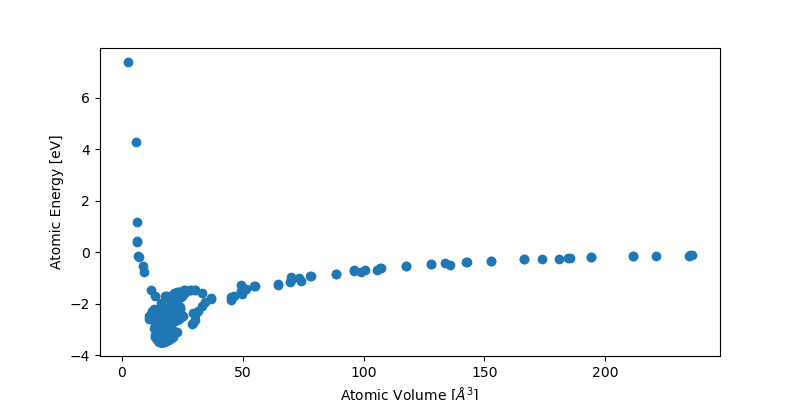

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
data_full.plot.energy_volume()
plt.show()

As you can see in this plot, some regions of configuration space are much more densily sampled than others. The dataset consists of approximately 4000 structures, ranging from bulk lithium and aluminum to off-stochiometric liquid phases of LiAl alloy. 

Training a potential for such a large dataset to high accuracy takes a few hours. Therefore, we are going to focus on a case study: the subset of pure lithium structures in the dataset. 

We extract a sample from the full dataset using `TrainingContainer`s convenient `sample` function. It creates a new `TrainingContainer` job (here we give it the name `data_lithium`) using a simple filter function. The filter function will remove:
* structures that contain Al.
* structures with a positive energy.
* structures in which atoms do not have any neighbors within a cutoff radius of 12 Bohr.

In [20]:
def filter_lithium(container, idx):
    """Filter a given `container` for the most useful lithium structures."""
    # Get the elements, total energy and atomic positions.
    elements = container.get_array('symbols', idx)
    energy = container.get_array('energy', idx)
    positions = container.get_array('positions', idx)

    # Build the distance matrix.
    distmatrix = get_distances(positions, positions)[1]

    # Check if every atom has at least one neighbor in a 12 Bohr = 6.35 Ang                                                                                                          
    # cutoff radius.
    no_neighbors = False
    for idx, row in enumerate(distmatrix):

        # Remove self interaction.                                                                                                                                                        
        row_no_selfinteraction = row[row > 0.0]

        if all(row_no_selfinteraction > 6.35):
            no_neighbors = True
    
    return 'Al' not in elements and energy < 0.0 and no_neighbors is False

In [21]:
# Remove the job if it already exists.
if 'data_lithium' in pr.list_nodes():
    pr.remove_job('data_lithium')

data_lithium = data_full.sample('data_lithium', filter_lithium)

The job data_lithium was saved and received the ID: 766


In [22]:
print(len(list(data_lithium.iter_structures())))

176


When inspecting the list of jobs in the project again, you will find that an additional `TrainingContainer` has been created.

In [23]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,62,finished,None,offstoichiometry,/offstoichiometry,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-20 07:40:54.302418,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
1,63,finished,None,activelearning,/activelearning,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-28 16:15:40.324613,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
2,64,finished,None,initial,/initial,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-31 17:51:21.146898,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
3,65,finished,None,full,/full,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-05-31 18:00:11.223627,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,NaN,None
4,66,finished,None,data_initial_sampled,/data_initial_sampled,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-06-02 20:08:49.404125,NaT,NaN,pyiron@jupyter-a-2eknoll#1,TrainingContainer,0.4,NaN,None
5,67,finished,None,data_off_sampled,/data_off_sampled,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-06-02 20:08:57.016915,NaT,NaN,pyiron@jupyter-a-2eknoll#1,TrainingContainer,0.4,NaN,None
6,68,finished,None,fit_mode1,/fit_mode1,None,/home/jovyan/workshop_preparation/introduction/unpack/fit_hdnnp/,2022-06-02 20:14:21.345133,2022-06-02 20:15:48.139703,86.0,pyiron@jupyter-a-2eknoll#1,RunnerFit,0.4,NaN,None
7,69,finished,None,fit_mode2,/fit_mode2,None,/home/jovyan/workshop_preparation/introduction/unpack/fit_hdnnp/,2022-06-02 20:16:06.795480,2022-06-02 21:17:22.699567,3675.0,pyiron@jupyter-a-2eknoll#1,RunnerFit,0.4,68.0,None
8,70,finished,None,fit_mode3,/fit_mode3,None,/home/jovyan/workshop_preparation/introduction/unpack/fit_hdnnp/,2022-06-02 21:17:33.128118,2022-06-02 21:21:25.621709,232.0,pyiron@jupyter-a-2eknoll#1,RunnerFit,0.4,69.0,None
9,766,finished,None,data_lithium,/data_lithium,None,/home/jovyan/workshop_preparation/introduction/unpack/initial/,2022-06-03 08:42:32.956467,NaT,NaN,pyiron@jupyter-a-2eknoll#1,TrainingContainer,0.4,NaN,None


For comparison, here is the energy-volume curve from before, overlayed with the structures in the reduced dataset.

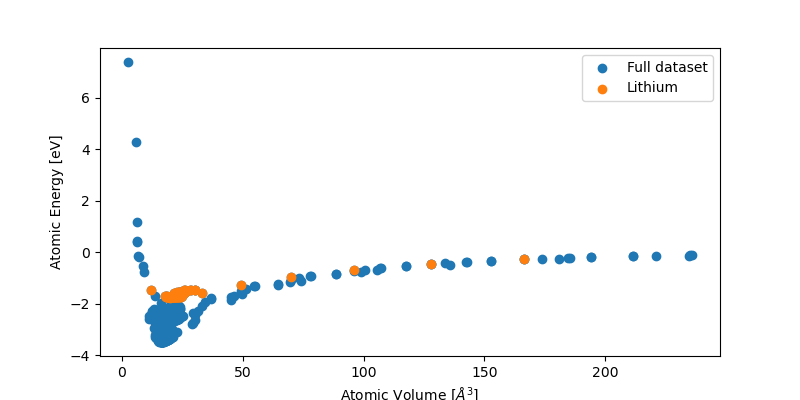

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
data_full.plot.energy_volume()
data_lithium.plot.energy_volume()
plt.legend(['Full dataset', 'Lithium'])
plt.show()

As you can see, we have selected a very small part of the dataset for our demonstration (176 of ~4000 structures). Nevertheless, the following chapters will demonstrate all the relevant RuNNer concepts to create a similar potential with more training data. 

## The `RunnerFit` Job

pyiron and the RuNNer Fortran program communicate via a custom job type called `RunnerFit`. Here, we add a new job to the project via `create_job` and give it the name `fit_data_lithium`.

In [25]:
pr_fit = pr.create_group('fit_lithium')

In [26]:
mode1 = pr_fit.create.job.RunnerFit('fit_mode1', delete_existing_job=True)

Every `RunnerFit` job is initialized with a sensible choice of input parameters for RuNNer (`parameters`) and an empty storage for training structures (`training_data`). This information can easily be accessed through the `input` property.  

In [27]:
mode1.input

DataContainer({'parameters': DataContainer({'runner_mode': 1, 'symfunction_short': [], 'elements': None, 'number_of_elements': 0, 'bond_threshold': 0.5, 'nn_type_short': 1, 'use_short_nn': True, 'optmode_charge': 1, 'optmode_short_energy': 1, 'optmode_short_force': 1, 'points_in_memory': 1000, 'scale_symmetry_functions': True, 'cutoff_type': 1, 'test_fraction': 0.1, 'use_short_forces': True, 'epochs': 30, 'kalman_lambda_short': 0.98, 'kalman_nue_short': 0.9987, 'mix_all_points': True, 'nguyen_widrow_weights_short': True, 'repeated_energy_update': True, 'short_energy_error_threshold': 0.1, 'short_energy_fraction': 1.0, 'short_force_error_threshold': 1.0, 'short_force_fraction': 0.1, 'use_old_weights_charge': False, 'use_old_weights_short': False, 'write_weights_epoch': 5, 'center_symmetry_functions': True, 'precondition_weights': True, 'global_activation_short': [['t', 't', 'l']], 'global_hidden_layers_short': 2, 'global_nodes_short': [[15, 15]]}), 'training_data': <pyiron_contrib.atomistics.atomistics.job.trainingcontainer.TrainingStorage object at 0x7efc87a1edc0>})

### Description of the Parameters in this Dictionary.

Here, we will only explain the global keywords which are relevant for all modes. The remaining keywords will be explained in following chapters. If a keyword is not specified on the pyiron-side, the **RuNNer** Fortran program uses default values, if possible.
For a more detailed explanation of all RuNNer keywords, take a look at [the RuNNer documentation](https://theochemgoettingen.gitlab.io/RuNNer).

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| Choose the operating mode of RuNNer.
|symfunction_short | empty `SymmetryFunctionSet` |Specification of the symmetry functions for a specific element with a specific neighbor element combination for the short-range NN.
|elements | None| The element symbols of all elements in the system in arbitrary order. The number of specified elements must fit to the value of the keyword number_of_elements. Will be automatically set by `pyiron`.
|number_of_elements | 0| Specify the number of chemical elements in the system. Will be automatically set by `pyiron`.
|bond_threshold | 0.5| Threshold for the shortest bond in the structure in Bohr units. If a shorter bond occurs RuNNer will stop with an error message in runner_mode 2 and 3. In runner_mode 1 the structure will be eliminated from the data set.
|nn_type_short | 1| Specify the NN type of the short-range part (atomic or pair-based energy expression).
|use_short_nn | True| Use the a short range NN. 
|points_in_memory | 1000| This keyword controls memory consumption and IO and is therefore important to achieve an optimum performance of RuNNer. Has a different meaning depending on the current runner_mode.
|use_short_forces | True| Use forces for fitting the short range NN weights.

### Adding Training Data

As of yet, this job does not have a training dataset. However, as you already saw for the EAM potential, adding a new training dataset to the job is as simple as calling `add_training_data`:

In [28]:
# The if-conditions prevents you from accidentally adding the same
# structures twice to the training dataset.
if len(mode1.training_data) == 0:
    mode1.add_training_data(data_lithium)

len(mode1.training_data)

176

By calling `add_training_data` multiple times, it is very easy to combine several independent training datasets for one fit.

### Specification of RuNNer Parameters

While many of the default parameters in `RunnerFit` are suited for a wide range of calculations, you still need to carefully check each of them before starting a fit. Special attention must be given to the atom-centered symmetry functions as they have to be tailored to the system under investigation.

#### Generating Symmetry Functions with runnerase

`RunnerFit` builds on the RuNNer ASE interface which is publicly available as `runnerase`. For further information check out the [runnerase documentation](https://runner-suite.gitlab.io/runnerase).

`runnerase` provides a `generate_symmetryfunction` procedure, which makes it easy to tailor SFs to the corresponding training dataset. You can either generate radial SFs by setting `sftype=2`, or angular SFs with `sftype=3`. The algorithm will then automatically generate one set of SFs for each pair or each triplet of elements in the dataset. The number of SFs per set can be specified with the `amount` argument. Finally, `generate_symmetryfunctions` comes with several different `algorithm`s for choosing the parameters of the SFs:
* **Radial SFs:** One can choose from `algorithm=turn` and `algorithm=half`. `turn` will choose the SF coefficients such that the turning points of all SFs are equally spaced between the cutoff radius and the minimum distance between any given element pair. `half` will make sure that the SFs are equally spaced at $f(G) = 0.5$.
* **Angular SFs:** One can choose from `algorithm=turn`, `algorithm=half`, or `algorithm=literature`. While the first two algorithms behave similarly to the ones for radial SF, `literature` will return SF coefficients that have proven to be a reliable choice for most systems in previous publications.

In most RuNNer-related publications, a combination of `algorithm=turn` for radial SFs and `algorithm=literature` for angular SFs has been used.

However, `runnerase` does not operate on pyiron objects like the `TrainingContainer`. Therefore, we transform the `TrainingContainer` with our lithium structures into a List of ASE Atoms objects. The `container_to_ase` function is defined in pyiron_contrib. 

In [29]:
dataset = container_to_ase(data_lithium)

In the following, we have prepared two interactive plotting functions for you, so you can try out different parameters for the SFs.

In [30]:
%matplotlib inline

@widgets.interact(amount=(0, 12, 1), algorithm=['turn', 'half'],
                  cutoff_function=[True, False], show_legend=[True, False])
def update(amount=6, algorithm='turn', cutoff_function=True, show_legend=False):
    # Clear the plot.
    plt.clf()
    ax = plt.gca()
    
    # Generate the symmetry functions.
    radials = generate_symmetryfunctions(dataset, sftype=2, algorithm=algorithm,
                                         cutoff=12.0, amount=amount)
    radials.plot.radial(cutoff_function=cutoff_function, show_legend=show_legend, axes=ax)
    plt.show()

interactive(children=(IntSlider(value=6, description='amount', max=12), Dropdown(description='algorithm', opti…

In [ ]:
@widgets.interact(amount=(0, 12, 1), algorithm=['half', 'turn', 'literature'],
                  show_legend=[True, False])
def update(amount = 4, algorithm='literature', show_legend=False):
    plt.clf()
    ax = plt.gca()
    angulars = generate_symmetryfunctions(dataset, sftype=3, amount=amount,
                                          algorithm=algorithm, cutoff=12.0)
    angulars.plot.angular(axes=ax, show_legend=show_legend)

#### Adding SFs to the Job

The parameter `mode1.parameters.symfunction_short` is, in fact, a so-called `SymmetryFunctionSet` object. They function similar to a folder: you can either store `SymmetryFunction` objects directly (= a file), or create more `SymmetryFunctionSet`s in them (= another folder).

When `generate_symmetryfunctions` is called, it returns a `SymmetryFunctionSet` itself. Two `SymmetryFunctionSet`s can easily be combined using the `+` operator. This way, we can add a collection of radial symmetry functions to our job.

In [31]:
# Reset the symmetry function container.
mode1.parameters.symfunction_short.reset()

# Generate radial symmetry functions.
radials = generate_symmetryfunctions(dataset, sftype=2, algorithm='half',
                                     cutoff=12.0)

mode1.parameters.symfunction_short += radials

All SFs stored in `radials` can be accessed through its `storage` property. As you can see, `radials` essentially organizes a list of SFs in a convenient storage format.

In [32]:
radials.storage

[SymmetryFunction(sftype=2, cutoff=12.0, elements=['Li', 'Li'], coefficients=[0.0, 0.0]),
 SymmetryFunction(sftype=2, cutoff=12.0, elements=['Li', 'Li'], coefficients=[0.004675055980246071, 0.0]),
 SymmetryFunction(sftype=2, cutoff=12.0, elements=['Li', 'Li'], coefficients=[0.010843416275634649, 0.0]),
 SymmetryFunction(sftype=2, cutoff=12.0, elements=['Li', 'Li'], coefficients=[0.01939424193215976, 0.0]),
 SymmetryFunction(sftype=2, cutoff=12.0, elements=['Li', 'Li'], coefficients=[0.03192971575337408, 0.0]),
 SymmetryFunction(sftype=2, cutoff=12.0, elements=['Li', 'Li'], coefficients=[0.05159916711157464, 0.0])]

Similarly, we can generate a set of angular symmetry functions and add them to the job as well.

In [34]:
# Generate angular symmetry functions.                                                                                                                                                                                                                        
angulars = generate_symmetryfunctions(dataset, sftype=3, amount=4,
                                      algorithm='literature', cutoff=12.0)

mode1.parameters.symfunction_short += angulars

In [35]:
angulars.storage

[SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, -1.0, 1]),
 SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, -1.0, 2]),
 SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, -1.0, 4]),
 SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, -1.0, 8]),
 SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, 1.0, 1]),
 SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, 1.0, 2]),
 SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, 1.0, 4]),
 SymmetryFunction(sftype=3, cutoff=12.0, elements=['Li', 'Li', 'Li'], coefficients=[0.0, 1.0, 8])]

When we look at the `input` of the job again, you will find that all symmetry functions appear.

In [36]:
mode1.input

DataContainer({'parameters': DataContainer({'runner_mode': 1, 'symfunction_short': [('Li', 2, 'Li', 0.0, 0.0, 12.0), ('Li', 2, 'Li', 0.004675055980246071, 0.0, 12.0), ('Li', 2, 'Li', 0.010843416275634649, 0.0, 12.0), ('Li', 2, 'Li', 0.01939424193215976, 0.0, 12.0), ('Li', 2, 'Li', 0.03192971575337408, 0.0, 12.0), ('Li', 2, 'Li', 0.05159916711157464, 0.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 1, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 2, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 4, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 8, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 1, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 2, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 4, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 8, 12.0)], 'elements': None, 'number_of_elements': 0, 'bond_threshold': 0.5, 'nn_type_short': 1, 'use_short_nn': True, 'optmode_charge': 1, 'optmode_short_energy': 1, 'optmode_short_force': 1, 'points_in_memory': 1000, 'scale_symmetry_functions': True, 'cutoff_type': 1, 'test_fraction': 0.1, 'use_short_forces': True, 'epochs': 30, 'kalman_lambda_short': 0.98, 'kalman_nue_short': 0.9987, 'mix_all_points': True, 'nguyen_widrow_weights_short': True, 'repeated_energy_update': True, 'short_energy_error_threshold': 0.1, 'short_energy_fraction': 1.0, 'short_force_error_threshold': 1.0, 'short_force_fraction': 0.1, 'use_old_weights_charge': False, 'use_old_weights_short': False, 'write_weights_epoch': 5, 'center_symmetry_functions': True, 'precondition_weights': True, 'global_activation_short': [['t', 't', 'l']], 'global_hidden_layers_short': 2, 'global_nodes_short': [[15, 15]]}), 'training_data': <pyiron_contrib.atomistics.atomistics.job.trainingcontainer.TrainingStorage object at 0x7efc87a1edc0>})

## Calculation of Symmetry Function Values - RuNNer Mode 1

In **RuNNer**'s mode 1 the following steps are performed:
- calculation of SF values,
- splitting of data set in train and test data set.

The most important keywords for RuNNer mode 1 are summarized in the following table. Previously unmentioned keywords are marked in bold font.

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| 
|symfunction_short | empty `SymmetryFunctionSet`| Specification of the symmetry functions for a specific element with a specific neighbor element combination for the short-range NN.
|elements | None| The element symbols of all elements in the system in arbitrary order. The number of specified elements must fit to the value of the keyword number_of_elements.
|number_of_elements | 0| Specify the number of chemical elements in the system.
|points_in_memory | 1000| This keyword controls memory consumption and IO and is therefore important to achieve an optimum performance of RuNNer. Has a different meaning depending on the current runner_mode.
|**cutoff_type** | 1| This keyword determines the cutoff function to be used for the symmetry functions.
|**test_fraction** | 0.1| Threshold for splitting between training and testing set in runner_mode 1.
|use_short_forces | True| Use forces for fitting the short range NN weights.
|**random_seed** | None | The seed for ensuring reproducible results. Will be chosen automatically by pyiron if none was supplied.

Finally, starting mode 1 is as simple as calling the `run` function. For safety, we reset the `runner_mode` parameter to 1. 

In [37]:
# Run Mode 1.
mode1.parameters.runner_mode = 1
mode1.run(delete_existing_job=True)

The job fit_mode1 was saved and received the ID: 767


### Output Mode 1

The output of the calculation is stored in the `output` property of the job.

In [38]:
mode1.output

DataContainer({'sfvalues': <pyiron_contrib.atomistics.runner.storageclasses.HDFSymmetryFunctionValues object at 0x7efc8783af70>, 'splittraintest': HDFSplitTrainTest(n_train=154, n_test=22)})

As you can see, `output` is a `DataContainer` with two nodes: the calculated SF values (`sfvalues`) and the split between training and testing data (`splittraintest`). The data is encapsulated in corresponding objects, e.g. `HDFSplitTrainTest`.

_For those who are interested: the object `HDFSplitTraintTest` wraps a similar object that is provided by the runnerase package (`RunnerSplitTrainTest`). This is necessary to provide the runnerase object with the capabilities to read and write itself to and from HDF format. Apart from these additional functions, the two classes behave completely the same. All output values of the RunnerFit job are stored in this way. `HDFSymmetryFunctionValues` is an exception: because SF values are very large, they are stored on the pyiron-side in a flat storage array. Therefore, `HDFSymmetryFunctionValues` and `RunnerSymmetryFunctionValues` behave differently. In order to work with `HDFSymmetryFunctionValues` more conveniently, we therefore convert it back to the `RunnerSymmetryFunctionValues` class by calling its `to_runnerase` routine._

We store the two different output values in variables and access their plotting interfaces.

In [ ]:
split = mode1.output['splittraintest']
sfvalues = mode1.output['sfvalues'].to_runnerase()

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
split.plot.pie()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sfvalues.plot.boxplot()
plt.show()

The boxplot above shows the distribution of SF values in the entire dataset for each SF. Outliers are depicted with black kites and every point corresponds to one atom.

This plot can give clues about outliers in the datatset which are difficult to fit. For example, symmetry function 7 shows very large values for one atom. This could indicate, that two atoms are getting unreasonably close (for radial SFs) or that their angle is very narrow (for angular SFs). Investigating such structures and, if necessary, removing them from the training dataset, can often improve a fit.    

### Potential Training - RuNNer Mode 2

In ``mode 2``, the magic happens and your data will be fitted. Again, we summarize important keywords in a table. There are many other keywords which allow you to finetune your potential. However, the selection below should give you many possibilities to change the outcome of the training process.

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| Must be set to 2.
|nn_type_short | 1| Specify the NN type of the short-range part.
|use_short_nn | True| Use the a short range NN. Whether an atomic or pair-based energy expression is used is determined via the keyword nn_type_short.
|**optmode_short_energy** | 1| Specify the optimization algorithm for the short-range energy contributions.
|**optmode_short_force** | 1| Specify the optimization algorithm for the short-range forces.
|points_in_memory | 1000| This keyword controls memory consumption and IO and is therefore important to achieve an optimum performance of RuNNer. Has a different meaning depending on the current runner_mode.
|**scale_symmetry_functions** | True| Rescale symmetry functions to a certain interval (the default interval is 0 to 1). This has numerical advantages if the orders of magnitudes of different symmetry functions are very different. If the minimum and maximum value for a symmetry function is the same for all structures, rescaling is not possible and RuNNer will terminate with an error. The interval can be specified by the keywords 
|use_short_forces | True| Use forces for fitting the short range NN weights.
|**epochs** | 30| The number of epochs for fitting. If 0 is specified, RuNNer will calculate the error and terminate without adjusting weights.
|**kalman_lambda_short** | 0.98| Kalman filter parameter $\lambda$ for the short range NN weight updates.
|**kalman_nue_short** | 0.9987| Kalman filter parameter $\nu$ for the short range weight updates.
|**mix_all_points** | True| Randomly reorder the data points in the data set at the beginning of each new epoch.
|**nguyen_widrow_weights_short** | True| Initialize the short-range NN weights according to the scheme proposed by Nguyen and Widrow. The initial weights and bias values in the hidden layer are chosen such that the input space is evenly distributed over the nodes. This may speed up the training process.
|**repeated_energy_update** | True| If this keyword is set, the weights of the short-range NN are updated a second time after the force update with respect to the total energies in the data set. This usually results in a more accurate potential energy fitting at the cost of slightly detiorated forces.
|**center_symmetry_functions** | True| Shift the symmetry function values individually for each symmetry function such that the average is moved to zero. This may have numerical advantages, because zero is the center of the non-linear regions of most activation functions.
|**precondition_weights** | True| Shift the weights of the atomic NNs right after the initialization so that the standard deviation of the NN energies is the same as the standard deviation of the reference energies.
|**global_activation_short** | [['t' 't' 'l']]| Set the activation function for each hidden layer and the output layer in the short range NNs of all elements. 
|**global_hidden_layers_short** | 2| Set the default number of hidden layers in the short-range NNs of all elements. Internally 1 is added to maxnum_layers_short, which also includes the output layer.
|**global_nodes_short** | [[15 15]]| Set the default number of nodes in the hidden layers of the short-range NNs in case of nn_type_short 1. In the array, the entries 1 - maxnum_layersshort - 1 refer to the hidden layers. The first entry (0) refers to the nodes in the input layer and is determined automatically from the symmetry functions.

During the fitting process of the NN, the error function $\Gamma$ is minimized, which is defined as 
\begin{equation}
    \Gamma = \mathrm{RMSE}(E)=\frac{1}{N_\mathrm{struct}} \sum_{i}^{N_\mathrm{\mathrm{struct}}} (E_{\mathrm{NN}}^{i} - E_{\mathrm{ref}}^{i})^2,
\end{equation}
if only energy fitting is used, which defines simultaneously the root-mean squared error of the energies $\mathrm{RMSE}(E)$. This defines the differences of the reference data and the NNP predictions.

In order to run mode 2, we will restart the previous calculation, thereby creating a new job with its own folder structure. This way, we can try different combinations of parameters without overwriting any of the previous results. 

Moreover, we will change some of the default parameters of the job. We reduce the number of epochs to 15 to keep the runtime short for this tutorial. Apart from that, we turn on force fitting (`use_short_forces=True`). This is turned off by default as force fitting is much more computationally demanding than pure energy fitting.

The next cell will run a few minutes.

In [ ]:
# Run Mode 2.
mode2 = mode1.restart('fit_mode2')
mode2.parameters.runner_mode = 2
mode2.parameters.epochs = 15
mode2.parameters.use_short_forces = True
mode2.run(delete_existing_job=True)

After the job has finished, we can first take a look at the behaviour of the error function, i.e. the RMSE. The `output` of mode 2 consists of three properties: the results of the fitting process (`fitresults`), the optimized weights and the symmetry function scaling data for shifting to zero mean and unit variance (`scaling`).

In [ ]:
mode2.output['fitresults'].table()

The `table` function already shows you that both the energy and force RMSE are declining. The best epoch is determined by the energy RMSE on the **test** set that is lowest.

A more accessible analysis can be obtained by looking at the plots of this data.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
mode2.output['fitresults'].plot.rmse_e()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
mode2.output['fitresults'].plot.rmse_f()
plt.show()

The RMSE of the test set is consistently lower than that of the training set. This is because we are using a very small test set including only 17 structures. In contrast to that, you could identify overfitting, if the train RMSE were much lower than the test RMSE.

Nevertheless, the RMSE is a rather strong reduction of the really complex potential energy surface (PES) and can only be understood as a rule of thumb for the quality of the NNP fit.

## Potential Evaluation - RuNNer Mode 3

**RuNNer** ``mode 3`` is the prediction mode and brings the NNP to application. 

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| Must be set to 3.
|calculate_forces | True| Calculate the atomic forces in runner_mode 3 and write them to the files runner.out and nnforces.out.

We start the calculation following the same pattern as for mode 2.

In [ ]:
# Run Mode 3.
mode3 = mode2.restart('fit_mode3')
mode3.parameters.runner_mode = 3
mode3.parameters.calculate_forces = True
mode3.run(delete_existing_job=True)

As we turned on `calculate_forces`, mode 3 will give us the energy and force for each structure in the training and testing datasets. Take a look at the `output` to see that we now have access to all possible output properties.

In [41]:
mode3.output.list_nodes()

NameError: name 'mode3' is not defined

For a more detailed analyze, we can have a look at the atomic energy and force prediction of the NNP compared to the reference values. For a perfect fit, all points will be on the diagonal of the plot. In this plot, we can identify, for example, whether some energies ranges are not well described in our data set. This could be related to our first data set analysis above.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
mode3.plot.energy_scatter_histogram()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
mode3.plot.force_scatter_histogram(axis=0)
plt.show()

## Using the potential

After successfully running modes 1 through 3, the potential is ready for application. Via [n2p2](https://compphysvienna.github.io/n2p2/index.html), the NNP can be used in combination with LAMMPS to drive large-scale atomistic simulations.

As was done for previous potentials, we create a pandas dataframe holding all the relevant pieces of information about the potential using `get_lammps_potential`. **API break:** In our case, we need to specifically define the `elements` present in the simulations. Otherwise, the mapping between species in n2p2 and LAMMPS might be off.

In [ ]:
pot = mode3.get_lammps_potential(elements=['Li'])

display(pot)

As a first application, we are going to calculate the energy-volume curve of bulk lithium. This requires the minimization of structures with different cell geometries, a suitable first test for the stability of a new HDNNP.

We create a new subproject for these calculations:

In [ ]:
if 'E_V_curve' in pr.list_groups():
    pr['E_V_curve'].remove_jobs(silently=True)
pr_ev = pr.create_group('E_V_curve')

Next, we create Li bulk structures, varying the cell parameter `a` between 3.0 and 4.0 Angstrom. For each structure, we create a LAMMPS job that minimizes the energy of the system.

In [ ]:
a_list = np.linspace(3.0, 4.0, 7)
for a in a_list:
    job_name = f'job_a_{a:.4}'.replace('.', '_')
    job = pr_ev.create.job.Lammps(job_name, delete_existing_job=True)
    job.structure = pr_ev.create_ase_bulk('Li', a=a)
    job.potential = pot
    job.calc_minimize()
    job.run(delete_existing_job=True)

Finally, we create a plot from the collected data.

In [ ]:
volume_list = []
energy_list = []
for job in pr_ev.iter_jobs(status='finished'):
    min_volume = job['output/generic/volume'][-1]
    min_energy = job['output/generic/energy_tot'][-1]
    
    volume_list.append(min_volume)
    energy_list.append(min_energy)

volume_list = np.array(volume_list)
energy_list = np.array(energy_list)

fig, ax = plt.subplots(1, 1)
args = np.argsort(volume_list)
ax.plot(volume_list[args], energy_list[args], '-x')
plt.xlabel('Volume [$\mathrm{\AA^3}$]')
plt.ylabel('Energy [eV]')
plt.show()

### Playing with the Neural Network Potential

Great that you have already come this far in the notebook! If you still have some time left, we invite you to play with a few key parameters of RuNNer to experience firsthand how they can influence the fit.

**Important:** Feel free to change whatever parameters you find interesting. However, keep in mind that using a very large neural network architecture or a significantly bigger portion of the full dataset will result in very long training times much exceeding the timeframe of this tutorial.

Here are a few suggestions:

1. Choose a different training dataset.
2. Change `precondition_weights` to `False`.
3. Experience overfitting by choosing a larger neural network architecture. We recommend 3 hidden layers with 25 nodes each.
4. Experience a really quick fit by setting `use_short_forces` to `False`.
5. Observe that the training outcome can vary depending on different choices of the variable `random_seed`.

### Resources

Here is a collection of all the resources mentioned in the text. These are a very good starting points towards using RuNNer in your own research!

* Technical Documentation:
    * [The RuNNer documentation](https://theochemgoettingen.gitlab.io/RuNNer).
    * [The runnerase documentation](https://runner-suite.gitlab.io/runnerase/).
    * [The n2p2 documentation](https://compphysvienna.github.io/n2p2/index.html).
* Second Generation HDNNP:
    * [J. Behler, M. Parrinello, Phys. Rev. Lett. 2007, 98, 146401](https://www.doi.org/10.1103/PhysRevLett.98.146401).
    * [J. Behler, International Journal of Quantum Chemistry 2015, 115, 1032–1050](https://www.doi.org/10.1002/qua.24890).
    * [J. Behler, Angewandte Chemie International Edition 2017, 56, 12828–12840](https://www.doi.org/10.1002/anie.201703114).
* Third Generation HDNNP:
    * [N. Artrith, T. Morawietz, J. Behler, Phys. Rev. B 2011, 83, 153101](https://www.doi.org/10.1103/PhysRevB.83.153101).
    * [T. Morawietz, V. Sharma, J. Behler, J. Chem. Phys. 2012, 136, 064103](https://www.doi.org/10.1063/1.3682557).
* Fourth Generation HDNNP:
    * [T. W. Ko, J. A. Finkler, S. Goedecker, J. Behler, Nature Communications 2021, 12, 398](https://www.doi.org/10.1038/s41467-020-20427-2).
    * [T. W. Ko, J. A. Finkler, S. Goedecker, J. Behler, Acc. Chem. Res. 2021, 54, 808–817](https://www.doi.org/10.1021/acs.accounts.0c00689).
* Atom-centered Symmetry Functions:
    * [J. Behler, The Journal of Chemical Physics 2011, 134, 074106.](https://www.doi.org/10.1063/1.3553717).
* Further Reading / Tutorial Reviews:
    * [J. Behler, Journal of Physics: Condensed Matter 2014, 26, 183001](https://www.doi.org/10.1088/0953-8984/26/18/183001).
    * [J. Behler, Phys. Chem. Chem. Phys. 2011, 13, 17930–17955](https://www.doi.org/10.1039/C1CP21668F).
    * [J. Behler, International Journal of Quantum Chemistry 2015, 115, 1032–1050](https://www.doi.org/10.1002/qua.24890).